### Codigo para la propagación de onda elástica 2D PSV en un medio homogeneo mediante el esquema velocidad - esfuerzo y rejilla escalonada
En este Notebook se presenta un codigo para la propagación de onda elástica 2D PSV en un medio homogeneo mediante el esquema velocidad - esfuerzo y rejilla escalonada propuesto por Virieux (1986), como resultado se muestra en la figura 1 cuatro cuadros donde se muestra el avance de la onda P mediante la divergencia, la onda S mediante el rotor y las velocidades $v_x$ y $v_z$

#### Sistema de ecuaciones de onda elástica 2D
El sistema de ecuaciones para la propagación de la onda elástica en 2D en el esquema velocidad - esfuerzo donde el movimiento de la particula es en la dirección x (horizontal) y en la dirección z (vertical) son:

$$
\frac{\partial v_x}{\partial t} = \frac{1}{\rho} \left( \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{xz}}{\partial z} \right)
$$
$$
\frac{\partial v_z}{\partial t} = \frac{1}{\rho} \left( \frac{\partial \tau_{xz}}{\partial x} + \frac{\partial \tau_{zz}}{\partial z} \right)
$$
$$
\frac{\partial \tau_{xx}}{\partial t} = (\lambda + 2\mu)\frac{\partial v_x}{\partial x} + \lambda \frac{\partial v_z}{\partial z}
$$
$$
\frac{\partial \tau_{zz}}{\partial t} = (\lambda + 2\mu)\frac{\partial v_z}{\partial z} + \lambda \frac{\partial v_x}{\partial x}
$$
$$
\frac{\partial \tau_{xz}}{\partial t} = \mu \left( \frac{\partial v_x}{\partial z} + \frac{\partial v_z}{\partial x} \right)
$$

donde $ \rm {\rho} $ es la densidad, $ \rm {\lambda}$ y $ \rm {\mu}$ son los parámetros de Lamé, $ \rm{(v_x,\; v_z)}$ es el vector de velocidad de partículas , $ \rm {\tau_{xx}} $, $ \rm{\tau_{zz}} $, $ \rm{\tau_{xz}}$ son los componentes del tensor esfuerzo

#### Implementación númerica mediante el metodo de rejilla escalonada
Para la solución numérica de las ecuaciones de movimiento elásticas hay que discretizarlas en el tiempo y el espacio en una cuadrícula. Las velocidades de las partículas $\rm{\mathbf{v}}$, los esfuerzos $\rm{\tau_{ij}}$, los parámetros de Lamé $\rm{\lambda}$ y $\rm{\mu}$ son calculado y definido en coordenadas cartesianas discretas $\rm{x = i \; dx}$, $\rm{z = j \; dz}$ y tiempos discretos $\rm{t = n \; dt}$. $\rm{dx}$ y $\rm{dz}$ denota la distancia espacial entre dos puntos de cuadrícula adyacentes en el eje x y eje z respectivamente y $\rm{dt}$ es la diferencia entre dos pasos de tiempo sucesivos. Por lo tanto, cada punto de la cuadrícula se encuentra en el intervalo $\rm{i\ en N | [1, nx]}$, $\rm {j\ en N | [1, nz]}$ y $\rm{n\ en N | [1, nt]}$, donde $\rm{nx}$, $\rm{nz}$ y $\rm{nt}$ son el número de puntos discretos de la cuadrícula espacial y el número de pasos de tiempo, respectivamente.

Finalmente, las derivadas parciales se reemplazan por operadores **de diferencia finita (FD)**. Se pueden distinguir dos tipos de operadores, operadores hacia adelante y hacia atrás $ \rm {D^+, \; D^-}$. La derivada de una función f(x) con respecto a una variable x puede ser aproximada por los siguientes operadores de segundo orden:

$$\rm{D^+_x f = \frac{f_{i+1}-f_{i}}{dx} \hspace{1 cm} \text{operador hacia adelante}} $$

$$\rm{D^-_x f = \frac{f_i-f_{i-1}}{dx} \hspace{1 cm} \text{operador hacia atras}} $$

Para calcular las derivadas espaciales de las variables de campo de onda en las posiciones correctas entre sí, las variables no se colocan en los mismos puntos de la cuadrícula, sino que se escalonan por la mitad de la distancia del punto de la cuadrícula espacial (Virieux 1986). La Figura 1 muestra la distribución de los parámetros del material y las variables del campo de onda en la cuadrícula espacial.

![Staggered grid](./Staggered_grid.png)

En el siguiente paso, discretizamos las ecuaciones de movimiento para el problema 2D PSV utilizando un enfoque de diferencia finita escalonada. Primero, discretizamos la componente x de la ecuación de momento aproximando las derivadas espaciales

$$\rm{\frac{\partial \tau_{xx}}{\partial x} \approx \frac{\tau_{xx}(j,i+1) - \tau_{xx}(j,i)}{dx}}, \rm{\frac{\partial \tau_{xz}}{\partial z} \approx \frac{\tau_{xz}(j+1/2, i) - \tau_{xz}(j-1/2,i)}{dz}} $$

Y la derivada temporal viene dada por

$$\rho \rm{\frac{\partial v_x}{\partial t} \approx \rho_x(j,i+1/2) \frac{v_x^{n+1/2}(j,i+1/2) - v_x^{n-1/2}(j,i+1/2)}{dt}} $$

Insertandola en la ecuación diferencial parcial

$$\rm{\rho \frac{\partial v_x}{\partial t} = \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{xz}}{\partial z}} $$

lleva a

$$\rho_x(j,i+1/2) \frac{v_x^{n+1/2}(j,i+1/2) - v_x^{n-1/2}(j,i+1/2)}{dt} = \frac{\tau_{xx}^n(j,i+1) - \tau_{xx}^n(j,i)}{dx} + \frac{\tau_{xz}^n(j+1/2, i) - \tau_{xz}^n(j-1/2,i)}{dz} $$

Despues  reordenando  para $v_x^{n+1/2}(j,i+1/2)$ se obtiene el siguiente esquema de FD explicito para el componente  x del la ecuación de  momentum:

$$\rm{v_x^{n+1/2}(j,i+1/2) = v_x^{n-1/2}(j,i+1/2) + \frac{dt}{\rho_x(j,i+1/2)}\cdot \biggl(\frac{\tau^n_{xx}(j,i+1) - \tau^n_{xx}(j,i)}{dx} + \frac{\tau^n_{xz}(j+1/2, i) - \tau^n_{xz}(j-1/2,i)}{dz} \biggr)} $$

Usando un enfoque similar, podemos derivar el esquema FD para la componente y de la ecuación de momento ...

$$\rm{v_z^{n+1/2}(j,i+1/2) = v_z^{n-1/2}(j,i+1/2) + \frac{dt}{\rho_z(j+1/2,i)}\cdot \biggl(\frac{\tau^n_{xz}(j, i+1/2) - \tau^n_{xz}(j,i-1/2)}{dx} + \frac{\tau^n_{zz}(j+1,i) - \tau^n_{zz}(j,i)}{dz} \biggr)} $$

... y los esfuerzos ...

$$
\begin{split}   
\rm{\tau^{n+1}_{xx}(j,i)}\;&\rm{= \tau_{xx}^{n}(j,i) + dt\cdot\lambda(j,i)\cdot \biggl(v^{n+1/2}_{xx}(j,i) + v^{n+1/2}_{zz}(j,i) \biggr) + 2 dt\cdot  \mu(j,i) \cdot  v^{n+1/2}_{xx}(j,i)}\\ 
\rm{\tau^{n+1}_{zz}(j,i)}\;&\rm{= \tau_{zz}^{n}(j,i) + dt\cdot\lambda(j,i)\cdot \biggl(v^{n+1/2}_{xx}(j,i) + v^{n+1/2}_{zz}(j,i) \biggr) + 2 dt\cdot  \mu(j,i) \cdot  v^{n+1/2}_{zz}(j,i)}\\ 
\rm{\tau^{n+1}_{xz}(j+1/2,i+1/2)}\;&\rm{=\tau^{n}_{xz}(j+1/2,i+1/2) + dt\cdot\mu_{xz}(j+1/2,i+1/2)\biggl(v^{n+1/2}_{xz}(j+1/2,i+1/2) + v^{n+1/2}_{zx}(j+1/2,i+1/2)\biggr)}\\
\end{split}
$$

con las derivadas espaciales

$$
\begin{split}  
\rm{v_{xx}(j,i)}\; & \rm{= \frac{v_x(j,i+1/2)-v_x(j,i-1/2)}{dx}}\\ 
\rm{v_{zz}(j,i)}\; & \rm{= \frac{v_z(j+1/2,i)-v_z(j-1/2,i)}{dz}}\\ 
\rm{v_{zx}(j+1/2,i+1/2)}\; & \rm{= \frac{v_z(j+1/2, i+1)-v_z(j+1/2, i)}{dx}}\\ 
\rm{v_{xz}(j+1/2,i+1/2)}\; & \rm{= \frac{v_x(j+1,i+1/2)-v_x(j, i+1/2)}{dz}}\\
\end{split}
$$

#### Termino o función fuente

En este codigo se uso como función fuente se uso una ondicula  cuya ecuación es:

$$
s= exp\left(-f_0^2*((t-t_0)*dt)^2\right)
$$

donde $f_0$ es la frecuencia dominante y $t_0$ es el retraso en tiempo

In [3]:
# Import Libraries 
# ----------------------------------------------
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def d(comp,inpu,dire):
    if(comp=='x'): idim = 0
    elif(comp=='z'): idim = 1
    
    if(dire == '+'):
        return (np.roll(inpu, -1, axis = idim)-inpu)/dx
    elif(dire == '-'):
        return (inpu - np.roll(inpu, 1, axis = idim))/dx

In [11]:
# Input Parameter
# ----------------------------------------------

# Discretization
c1=20           # Number of grid points per dominant wavelength
c2=0.6          # CFL-Number
nx=400          # number of grid points in x-direction
nz=400          # number of grid points in z-direction
Tt=0.50
idisp = 5 # display frequency
 
# Source Signal
f0= 25      # Center frequency Ricker-wavelet
aa= 1/f0
q0= 1      # Maximum amplitude Ricker-Wavelet
xscr = int(nx/2)-1;  zscr = int(nz/2)-1 # Source position (in grid points)

In [12]:
# Velocity and density
model_vp=3000   # P-wave velocity in m/s
model_vs=1500   # S-wave velocity in m/s
rho= 2200      # Density in g/cm^3

In [13]:
## Preparation 

# Init wavefields
vx=np.zeros((nx,nz))
vz=np.zeros((nx,nz))
txx=np.zeros((nx,nz))
tzz=np.zeros((nx,nz))
txz=np.zeros((nx,nz))
#vz_x=np.zeros((nx,nz))
#vx_z=np.zeros((nx,nz))
#vx_x=np.zeros((nx,nz))
#vz_z=np.zeros((nx,nz))
vol   = np.zeros([nx,nz])
curl  = np.zeros([nx,nz])

# Calculate Lame  Parameters
lam=rho*(model_vp**2 - 2*model_vs**2)
mu=rho*model_vs**2 

cmin=model_vp  # Lowest P-wave velocity
cmax=model_vp  # Highest P-wave velocity
fmax=2*f0              # Maximum frequency
dx=cmin/(fmax*c1)      # Spatial discretization (in m)
dz=dx 
dt=dx/(cmax)*c2        # Temporal discretization (in s)
lampda_min=cmin/fmax   # Smallest wavelength

# Create space and time vector
x=np.arange(0,dx*nx-dx,dx) # Space vector
z=np.arange(0,(dz*nz-dz),dz) # Space vector
t=np.arange(0,(Tt-dt),dt)    # Time vector
nt=len(t)       # Number of time steps

In [14]:
# Source signal - Ricker-wavelet
#tau=np.pi*f0*(t-1.5/f0)
#q=q0*(1-2*tau**2)*np.exp(-tau**2)

# Initialise source
s = np.zeros(nt)
t0 = 3. * aa/dt
for i in range(1,nt+1):
    s[i-1]= np.exp(- 1./aa**2*((i-t0)*dt)**2)
print(' %r <source< %r' %(s.min(),s.max()))

# Plotting source signal
plt.ion()
fig4 = plt.figure(figsize=(9,4.5))
plt.plot(t,s)
plt.title('Source signal Ricker-Wavelet')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.show()

 7.017301340951494e-40 <source< 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


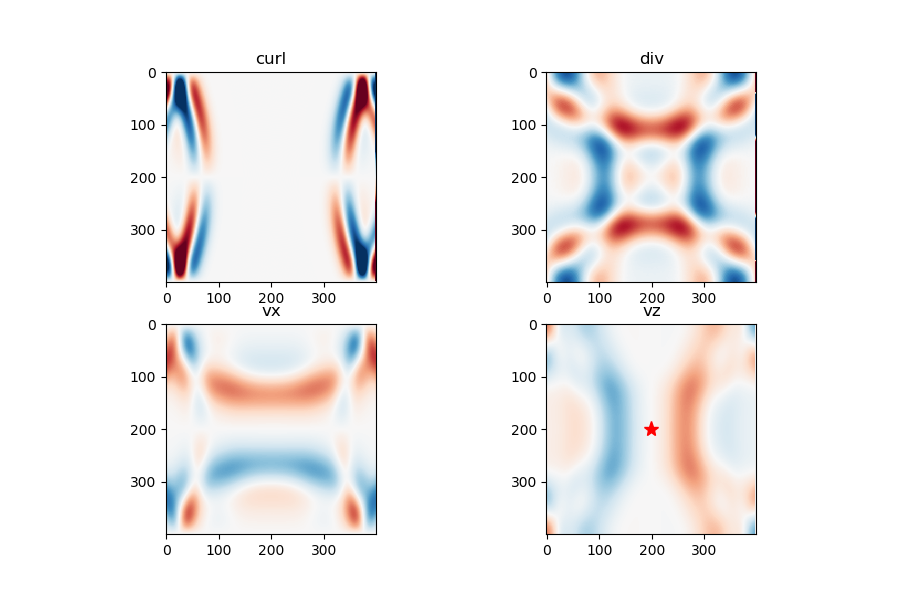

In [15]:
# Plot preparation
# Initialize animated plot
plt.ion()
fig5 = plt.figure(figsize=(9,6))
f1 = fig5.add_subplot(2, 2, 1)
f2 = fig5.add_subplot(2, 2, 2)
f3 = fig5.add_subplot(2, 2, 3)
f4 = fig5.add_subplot(2, 2, 4)
f1.set_title('curl')
f2.set_title('div')
f3.set_title('vx')
f4.set_title('vz')

curlp = f1.imshow(curl, interpolation='nearest', animated=True,
                   vmin=-1.0e-11, vmax=1.0e-11, cmap=plt.cm.RdBu)
divp = f2.imshow(vol, interpolation='nearest', animated=True,
                   vmin=-1.0e-11, vmax=1.0e-11, cmap=plt.cm.RdBu)
vxp = f3.imshow(vx, interpolation='nearest', animated=True,
                   vmin=-1.0e-09, vmax=1.0e-09, cmap=plt.cm.RdBu)
vzp = f4.imshow(vz, interpolation='nearest', animated=True,
                   vmin=-1.0e-09, vmax=1.0e-09, cmap=plt.cm.RdBu)

# Plot the receivers
#for x, z in zip(irx, irz):
#    plt.text(x, z, '+')

plt.plot(zscr, xscr, 'r*', markersize=11)
#plt.colorbar()
#plt.xlabel('ix')
#plt.ylabel('iz')
plt.show()


In [ ]:
for n in range(1,nt+1):

    # Inject source wavelet (explosion)
#    txx[xscr,zscr]=txx[xscr,zscr]+q[n]
#    tzz[xscr,zscr]=tzz[xscr,zscr]+q[n]
        
    txx[xscr,zscr]=txx[xscr,zscr]+s[int(n)-1]   
    tzz[xscr,zscr]=tzz[xscr,zscr]+s[int(n)-1]
    
    txx[:,0] = 0.
    tzz[:,0] = 0.
    txz[:,0] = 0.
    txx[:,nz-1] = 0.
    tzz[:,nz-1] = 0.
    txz[:,nz-1] = 0.
    
    # Update velocity
#    # Calculating spatial derivative
#    for i in range(1, nx-1):
#        for j in range(1, nz-1):
#            txx_x = (txx[i,j+1]-txx[i,j])/dx
#            tzz_z = (tzz[i+1,j]-tzz[i,j])/dz
#            txz_x = (txz[i,j]-txz[i,j-1])/dx
#            txz_z = (txz[i,j]-txz[i-1,j])/dz
           
    # Update velocity
    vx=vx+(dt/rho)*(d('x',txx,'-') + d('z',txz,'-'))
    vz=vz+(dt/rho)*(d('x',txz,'+') + d('z',tzz,'+'))
            
    curl = d('z',vx,'+') - d('x',vz,'-')
    vol = d('x',vx,'+') + d('z',vz,'-')            


#    # Calculating spatial derivative
#    for i in range(1, nx-1):
#        for j in range(1, nz-1):
#            vx_x[i,j] = (vx[i,j]-vx[i,j-1])/dx
#            vz_z[i,j] = (vz[i,j]-vz[i-1,j])/dz
#            vz_x[i,j] = (vz[i,j+1]-vz[i,j])/dx        
#            vx_z[i,j] = (vx[i+1,j]-vx[i,j])/dz
                       
    # Update pressure

    txx=txx+(lam *  vol + 2*mu * d('x',vx,'+')  ) * dt
    tzz=tzz+(lam *  vol + 2*mu * d('z',vz,'-')  ) * dt
    txz=txz+(mu * (d('z',vx,'+') + d('x',vz,'-') ) ) * dt 
                
        # Plot every time step (nt)
    if (n % idisp) == 0:
        #plt.title('Time Step (nt) = %d' % n)    
        curlp.set_data(curl)
        divp.set_data(vol)
        vxp.set_data(vx)
        vzp.set_data(vz)
        plt.gcf().canvas.draw()
        